# Automated Software Improvement: A Machine Learning Solution
## First Iteration - Prop Line Passed
### 2727141 Luke Skinner
### Supervisor: Dr Sandy Brownlee

## Overview

These notebookes contain all the work performed on the first iteration of the Machine Learning model(s) to help guide automated improvement of Software. The dataset provided for this iteration is "merged_stats_sb_17112020_amended.csv" (this was amended to fix an issue with a column which would have skewed a lot of the data) which is an aggregate of experimental results of edits performed on open source projects. This will include the first cycle of building an effective model. However, it is expected that this first iteration will not be sufficient for accurate results therefore the main goal of this iteration is to discover features which are important to both compiling and passing tests. These edits should be successful and when applied through Gin they should result in some reduction of runtime. Several Models will be made to target the two different styles of edits (line & statement). 

#### Imports

In [46]:
import seaborn as sns 
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import numpy as np
import matplotlib as plt
from scipy.stats import loguniform

#### Utility Functions

In [48]:
def cacl_adj_r2(r2, n, k):
    """
    Calculates the adjusted r2 score based on the following formula:
    Adjusted r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1). This is used to
    complement the original r2 score to give a better understanding of
    how the model explains variance of the predictor variables

    Parameters:
        r2 (float): The original r2 score (from sklearn)
        n (int): The number of observations
        k (int): The number of predictor variables

    Returns:
        adj_r2 (float): The adjusted r2 score 
    """
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)
    

#### Load Dataset

In [49]:
df = pd.read_csv('data/merged_stats_sb_17112020_amended.csv')

## Proposed Model 1 - Proportion Line Passed
## 1. Data Understanding

#### 1.1 Using Pandas to analyse dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157 entries, 0 to 2156
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CompositeKey                2157 non-null   object 
 1   Project                     2157 non-null   object 
 2   MethodIndex                 2157 non-null   int64  
 3   MethodName                  2157 non-null   object 
 4   numLines                    2157 non-null   int64  
 5   numStatements               2157 non-null   int64  
 6   EditDensity                 2157 non-null   float64
 7   AveUseDefDist               2157 non-null   float64
 8   NotDeclared                 2157 non-null   int64  
 9   AveUseDefDist/MethodLength  2157 non-null   float64
 10  MedDefUseDist               2157 non-null   float64
 11  MedUseDefDist/MethodLength  2157 non-null   float64
 12  CountLine                   2157 non-null   int64  
 13  CompiledLine                2157 

The majority of the dataset is made up of numeric data. CompositeKey, Project and MethodName will likely not be useful for predictions

In [22]:
df.head()

,CompositeKey,Project,MethodIndex,MethodName,numLines,numStatements,EditDensity,AveUseDefDist,NotDeclared,AveUseDefDist/MethodLength,...,PropStatPassed,cyclomatic,ncss,npath,cyc/length,ncss/length,npath/length,InstCoverage-missed,InstCoverage-covered,InstCoverage
0,arthas1,arthas,1,com.taobao.arthas.core.view.ObjectView.appendS...,6,5,843.250000,2.166667,0,0.361,...,0.433146,2,4,2,0.333333,0.666667,0.333333,0,26,1.000000
1,arthas2,arthas,2,com.taobao.arthas.core.view.ObjectView.renderO...,385,316,6.427746,130.182045,0,0.338,...,0.593525,93,262,122,0.241558,0.680519,0.316883,377,1326,0.778626
2,arthas3,arthas,3,com.taobao.arthas.core.util.TokenUtils.findSec...,16,15,329.100000,2.428571,0,0.152,...,0.189608,7,11,15,0.437500,0.687500,0.937500,0,35,1.000000
3,disruptor1,disruptor,1,com.lmax.disruptor.dsl.ConsumerRepository.getL...,13,9,72.181818,4.555556,0,0.350,...,0.256927,5,7,5,0.384615,0.538462,0.384615,0,38,1.000000
4,disruptor2,disruptor,2,com.lmax.disruptor.dsl.Disruptor.shutdown(long...,12,8,81.200000,3.500000,0,0.292,...,0.461823,4,6,4,0.333333,0.500000,0.333333,0,22,1.000000


In [23]:
df.tail()

,CompositeKey,Project,MethodIndex,MethodName,numLines,numStatements,EditDensity,AveUseDefDist,NotDeclared,AveUseDefDist/MethodLength,...,PropStatPassed,cyclomatic,ncss,npath,cyc/length,ncss/length,npath/length,InstCoverage-missed,InstCoverage-covered,InstCoverage
2152,spatial4j73,spatial4j,73,org.locationtech.spatial4j.shape.impl.Rectangl...,9,7,18.166667,4.214286,0,0.468,...,0.513761,2,5,-1,0.222222,0.555556,-0.111111,20,27,0.574468
2153,spatial4j74,spatial4j,74,org.locationtech.spatial4j.shape.ShapeCollecti...,4,2,131.000000,1.000000,0,0.250,...,0.351145,1,2,1,0.250000,0.500000,0.250000,0,4,1.000000
2154,spatial4j75,spatial4j,75,org.locationtech.spatial4j.shape.jts.JtsShapeF...,5,3,59.500000,1.250000,0,0.250,...,0.420168,1,3,1,0.200000,0.600000,0.200000,0,10,1.000000
2155,spatial4j76,spatial4j,76,org.locationtech.spatial4j.io.jackson.ShapeAsG...,105,104,123.000000,-1.000000,1,-0.010,...,0.536585,13,92,1,0.123810,0.876190,0.009524,75,341,0.819712
2156,spatial4j77,spatial4j,77,org.locationtech.spatial4j.shape.impl.InfBufLi...,12,11,9.285714,5.000000,0,0.417,...,0.153846,6,9,12,0.500000,0.750000,1.000000,0,49,1.000000


In [24]:
df.describe()

,MethodIndex,numLines,numStatements,EditDensity,AveUseDefDist,NotDeclared,AveUseDefDist/MethodLength,MedDefUseDist,MedUseDefDist/MethodLength,CountLine,...,PropStatPassed,cyclomatic,ncss,npath,cyc/length,ncss/length,npath/length,InstCoverage-missed,InstCoverage-covered,InstCoverage
count,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,...,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000
mean,313.783032,15.511358,13.588317,19.605347,5.093185,0.030598,0.330997,4.038016,0.294024,46.360686,...,0.310685,4.171998,11.667130,18.060732,0.289483,0.699992,0.576950,4.515531,51.709318,0.944227
std,244.588550,23.271079,23.072428,55.015178,11.613645,0.172266,0.475044,6.744969,0.445593,141.422205,...,0.169328,6.649563,20.112289,75.512102,0.122902,0.126637,1.635342,16.852915,91.004533,0.139312
min,1.000000,2.000000,1.000000,0.008158,-1.000000,0.000000,-0.333000,-1.000000,-0.333333,9.000000,...,0.000000,1.000000,1.000000,-1.000000,0.010753,0.085106,-0.500000,0.000000,0.000000,0.000000
25%,103.000000,4.000000,2.000000,1.846154,1.000000,0.000000,0.250000,1.000000,0.166667,19.000000,...,0.204082,1.000000,2.000000,1.000000,0.222222,0.666667,0.200000,0.000000,8.000000,0.986301
50%,266.000000,9.000000,7.000000,6.500000,2.333333,0.000000,0.333000,2.000000,0.285714,24.000000,...,0.312500,2.000000,6.000000,2.000000,0.285714,0.681818,0.312500,0.000000,23.000000,1.000000
75%,473.000000,17.000000,15.000000,22.000000,5.304348,0.000000,0.375000,4.000000,0.333333,34.000000,...,0.421053,4.000000,13.000000,6.000000,0.333333,0.776316,0.400000,1.000000,57.000000,1.000000
max,959.000000,470.000000,514.000000,862.000000,375.625000,1.000000,10.500000,62.000000,10.500000,3373.000000,...,0.833333,99.000000,468.000000,925.000000,1.666667,1.352941,29.090909,377.000000,1538.000000,1.000000


##### There are values in some of these columns which have minimums of -1, this is likely missing data when they were computed. Let's take a look at npath first

In [25]:
# Let's add a condition for npath > -1 and see the results
df[df.npath > -1].describe()

,MethodIndex,numLines,numStatements,EditDensity,AveUseDefDist,NotDeclared,AveUseDefDist/MethodLength,MedDefUseDist,MedUseDefDist/MethodLength,CountLine,...,PropStatPassed,cyclomatic,ncss,npath,cyc/length,ncss/length,npath/length,InstCoverage-missed,InstCoverage-covered,InstCoverage
count,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,...,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000
mean,304.881276,16.838389,14.862971,18.506873,5.535009,0.031381,0.334603,4.347542,0.293477,47.170502,...,0.300679,4.576360,12.697699,20.503138,0.293566,0.704820,0.683714,5.057531,55.770397,0.941467
std,244.409120,24.356899,24.175078,54.294212,12.242782,0.174390,0.499645,7.062341,0.468330,147.422364,...,0.157840,6.960036,21.099218,79.878446,0.124915,0.125361,1.707475,17.818635,94.331131,0.135296
min,1.000000,3.000000,2.000000,0.008158,-1.000000,0.000000,-0.333000,-1.000000,-0.333333,9.000000,...,0.000000,1.000000,2.000000,1.000000,0.010753,0.085106,0.009524,0.000000,0.000000,0.000000
25%,95.750000,5.000000,4.000000,1.644585,1.000000,0.000000,0.250000,1.000000,0.166667,19.000000,...,0.200000,1.000000,3.000000,1.000000,0.222222,0.666667,0.250000,0.000000,10.000000,0.964031
50%,255.000000,10.000000,8.000000,5.154762,2.636364,0.000000,0.333000,2.000000,0.272727,25.000000,...,0.300000,3.000000,7.000000,3.000000,0.285714,0.695387,0.333333,0.000000,27.000000,1.000000
75%,456.000000,18.250000,17.000000,21.000000,5.833333,0.000000,0.382250,5.000000,0.333333,35.000000,...,0.400000,5.000000,14.000000,7.000000,0.333333,0.777778,0.434783,2.000000,61.000000,1.000000
max,959.000000,470.000000,514.000000,862.000000,375.625000,1.000000,10.500000,62.000000,10.500000,3373.000000,...,0.809524,99.000000,468.000000,925.000000,1.666667,1.352941,29.090909,377.000000,1538.000000,1.000000


##### This would reduce the size of the data down to 1912 but it now looks like both npath and npath / length have more reasonable mininums. Let's add a condition for AveUseDefDist next

In [26]:
df[df.AveUseDefDist == 0].describe()

,MethodIndex,numLines,numStatements,EditDensity,AveUseDefDist,NotDeclared,AveUseDefDist/MethodLength,MedDefUseDist,MedUseDefDist/MethodLength,CountLine,...,PropStatPassed,cyclomatic,ncss,npath,cyc/length,ncss/length,npath/length,InstCoverage-missed,InstCoverage-covered,InstCoverage
count,162.000000,162.000000,162.000000,162.000000,162.0,162.0,162.0,162.0,162.0,162.000000,...,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,268.925926,16.623457,14.080247,38.401235,0.0,0.0,0.0,0.0,0.0,38.401235,...,0.288377,4.580247,12.135802,45.907407,0.317695,0.678347,1.108067,5.265432,72.481481,0.947197
std,229.286757,19.777337,18.568984,38.141850,0.0,0.0,0.0,0.0,0.0,38.141850,...,0.179150,5.725315,16.114692,147.592935,0.165941,0.128696,2.854552,22.391157,112.548911,0.160730
min,1.000000,2.000000,1.000000,9.000000,0.0,0.0,0.0,0.0,0.0,9.000000,...,0.000000,1.000000,1.000000,-1.000000,0.010753,0.266667,-0.500000,0.000000,0.000000,0.000000
25%,68.000000,3.000000,2.000000,20.000000,0.0,0.0,0.0,0.0,0.0,20.000000,...,0.163655,1.000000,2.000000,1.000000,0.239177,0.625000,0.205556,0.000000,4.000000,1.000000
50%,209.500000,9.000000,7.500000,25.000000,0.0,0.0,0.0,0.0,0.0,25.000000,...,0.269697,2.000000,6.000000,2.000000,0.333333,0.666667,0.333333,0.000000,29.000000,1.000000
75%,407.000000,21.000000,18.000000,37.750000,0.0,0.0,0.0,0.0,0.0,37.750000,...,0.397709,6.000000,15.000000,8.000000,0.333333,0.750000,0.469886,0.000000,82.250000,1.000000
max,955.000000,121.000000,116.000000,186.000000,0.0,0.0,0.0,0.0,0.0,186.000000,...,0.809524,36.000000,101.000000,925.000000,1.666667,1.000000,17.454545,173.000000,617.000000,1.000000


In [27]:
df[(df.npath > -1)].describe()

,MethodIndex,numLines,numStatements,EditDensity,AveUseDefDist,NotDeclared,AveUseDefDist/MethodLength,MedDefUseDist,MedUseDefDist/MethodLength,CountLine,...,PropStatPassed,cyclomatic,ncss,npath,cyc/length,ncss/length,npath/length,InstCoverage-missed,InstCoverage-covered,InstCoverage
count,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,...,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000
mean,304.881276,16.838389,14.862971,18.506873,5.535009,0.031381,0.334603,4.347542,0.293477,47.170502,...,0.300679,4.576360,12.697699,20.503138,0.293566,0.704820,0.683714,5.057531,55.770397,0.941467
std,244.409120,24.356899,24.175078,54.294212,12.242782,0.174390,0.499645,7.062341,0.468330,147.422364,...,0.157840,6.960036,21.099218,79.878446,0.124915,0.125361,1.707475,17.818635,94.331131,0.135296
min,1.000000,3.000000,2.000000,0.008158,-1.000000,0.000000,-0.333000,-1.000000,-0.333333,9.000000,...,0.000000,1.000000,2.000000,1.000000,0.010753,0.085106,0.009524,0.000000,0.000000,0.000000
25%,95.750000,5.000000,4.000000,1.644585,1.000000,0.000000,0.250000,1.000000,0.166667,19.000000,...,0.200000,1.000000,3.000000,1.000000,0.222222,0.666667,0.250000,0.000000,10.000000,0.964031
50%,255.000000,10.000000,8.000000,5.154762,2.636364,0.000000,0.333000,2.000000,0.272727,25.000000,...,0.300000,3.000000,7.000000,3.000000,0.285714,0.695387,0.333333,0.000000,27.000000,1.000000
75%,456.000000,18.250000,17.000000,21.000000,5.833333,0.000000,0.382250,5.000000,0.333333,35.000000,...,0.400000,5.000000,14.000000,7.000000,0.333333,0.777778,0.434783,2.000000,61.000000,1.000000
max,959.000000,470.000000,514.000000,862.000000,375.625000,1.000000,10.500000,62.000000,10.500000,3373.000000,...,0.809524,99.000000,468.000000,925.000000,1.666667,1.352941,29.090909,377.000000,1538.000000,1.000000


##### This would further reduce the data down to 1852 but this looks much more reasonable. Supervisor Dr Sandy Brownlee suggested adding a > 10 filter on numLines, lets see what that looks like.

In [28]:
df[(df.npath > -1)  & (df.numLines > 10)].describe()
df[df.AveUseDefDist == -1].NotDeclared

30      1
49      1
65      1
90      1
100     1
       ..
1986    1
2072    1
2126    1
2135    1
2155    1
Name: NotDeclared, Length: 66, dtype: int64

##### The working set in this case would be 925

## Data Visualisation

##### To get the beginnings of an understanding, lets have a look at the overall correlations between the rest of the data at "PropLinePassed" - that is the proportion of lines which passed their unit tests

In [54]:
df.corrwith(df['PropLinePassed']).drop('PropLinePassed')

MethodIndex                   0.213195
numLines                      0.110567
numStatements                 0.124634
EditDensity                  -0.033739
AveUseDefDist                 0.115697
NotDeclared                   0.006910
AveUseDefDist/MethodLength    0.066969
MedDefUseDist                 0.133223
MedUseDefDist/MethodLength    0.044016
CountLine                    -0.010677
CompiledLine                  0.078609
PassedLine                    0.129381
CountStat                    -0.010677
CompiledStat                  0.025546
PassedStat                    0.060022
PropLineCompiled              0.816889
PropStatCompiled              0.443489
PropStatPassed                0.563709
cyclomatic                    0.076494
ncss                          0.130679
npath                         0.011387
cyc/length                   -0.071027
ncss/length                   0.122020
npath/length                 -0.034211
InstCoverage-missed           0.075117
InstCoverage-covered     

##### As expected, there is a high positive correlation between the proportion of lines passed and compiled

<AxesSubplot:xlabel='PropLineCompiled', ylabel='PropLinePassed'>

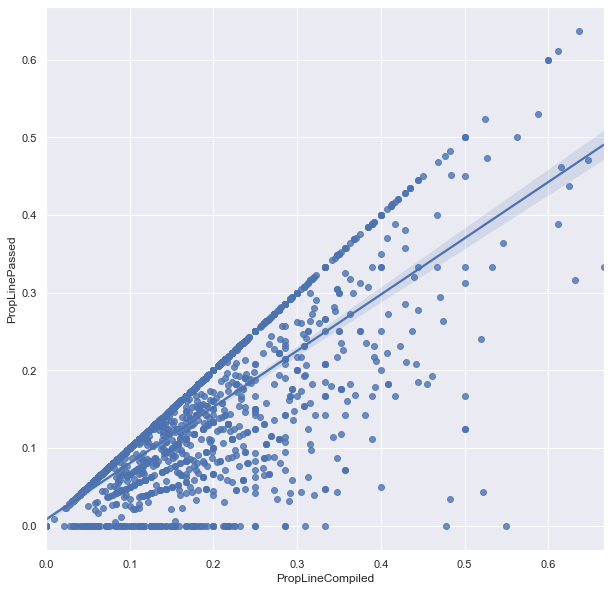

In [6]:
# Lets plot that using a regplot from seaborn
x_axis = df['PropLineCompiled']

y_axis = df['PropLinePassed']

sns.set(rc = {'figure.figsize' : (10, 10)})

sns.regplot(x=x_axis, y=y_axis)

##### Additionally, it seems like cyclomatic complexity and npath have a very low positive correlation. NCSS, MedUseDefDist and AveUseDefDistance have the highest out of the metrics

In [8]:
df.corrwith(df['PropLinePassed']).drop('PropLinePassed')

MethodIndex                   0.213195
numLines                      0.110567
numStatements                 0.124634
EditDensity                  -0.033739
AveUseDefDist                 0.115697
NotDeclared                   0.006910
AveUseDefDist/MethodLength    0.066969
MedDefUseDist                 0.133223
MedUseDefDist/MethodLength    0.044016
CountLine                    -0.010677
CompiledLine                  0.078609
PassedLine                    0.129381
CountStat                    -0.010677
CompiledStat                  0.025546
PassedStat                    0.060022
PropLineCompiled              0.816889
PropStatCompiled              0.443489
PropStatPassed                0.563709
cyclomatic                    0.076494
ncss                          0.130679
npath                         0.011387
cyc/length                   -0.071027
ncss/length                   0.122020
npath/length                 -0.034211
InstCoverage-missed           0.075117
InstCoverage-covered     

## 2. Data Preparation

In [50]:
# Lets remove the non numerical fields as they are not useful for the model
df_new = df.drop(['CompositeKey', 'Project', 'MethodName', 'MethodIndex', 'PropLineCompiled'], axis=1)

df_new.info() 

# We will filter out all rows which have a numLines < 10, we also want to only look at rows with sensible npath values
df_new = df_new[(df_new.numLines > 10) & (df.npath > -1) ]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157 entries, 0 to 2156
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   numLines                    2157 non-null   int64  
 1   numStatements               2157 non-null   int64  
 2   EditDensity                 2157 non-null   float64
 3   AveUseDefDist               2157 non-null   float64
 4   NotDeclared                 2157 non-null   int64  
 5   AveUseDefDist/MethodLength  2157 non-null   float64
 6   MedDefUseDist               2157 non-null   float64
 7   MedUseDefDist/MethodLength  2157 non-null   float64
 8   CountLine                   2157 non-null   int64  
 9   CompiledLine                2157 non-null   int64  
 10  PassedLine                  2157 non-null   int64  
 11  CountStat                   2157 non-null   int64  
 12  CompiledStat                2157 non-null   int64  
 13  PassedStat                  2157 

## 3. Beginning Train/Test split

##### We now want to identify the features which are most important, we will start by looking at all the other fields with respect to the target. First we will split the data 70%/30%.

In [24]:
X = df_new.drop(['PropStatCompiled', 'PropLinePassed', 'PropStatPassed'], axis=1)

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(647, 23)
(278, 23)
(647,)
(278,)


## 4. Feature Importances at a glance

##### To get the feature importances, we will first start by fitting an overall RandomForest model on the data and seeing what it produces as feature importances. This will not be the final model.

CompiledLine                  0.408653
PassedStat                    0.124471
CountLine                     0.107971
CountStat                     0.100787
ncss/length                   0.037185
InstCoverage-covered          0.032021
npath/length                  0.021579
CompiledStat                  0.019136
MedUseDefDist/MethodLength    0.017404
EditDensity                   0.016123
dtype: float64


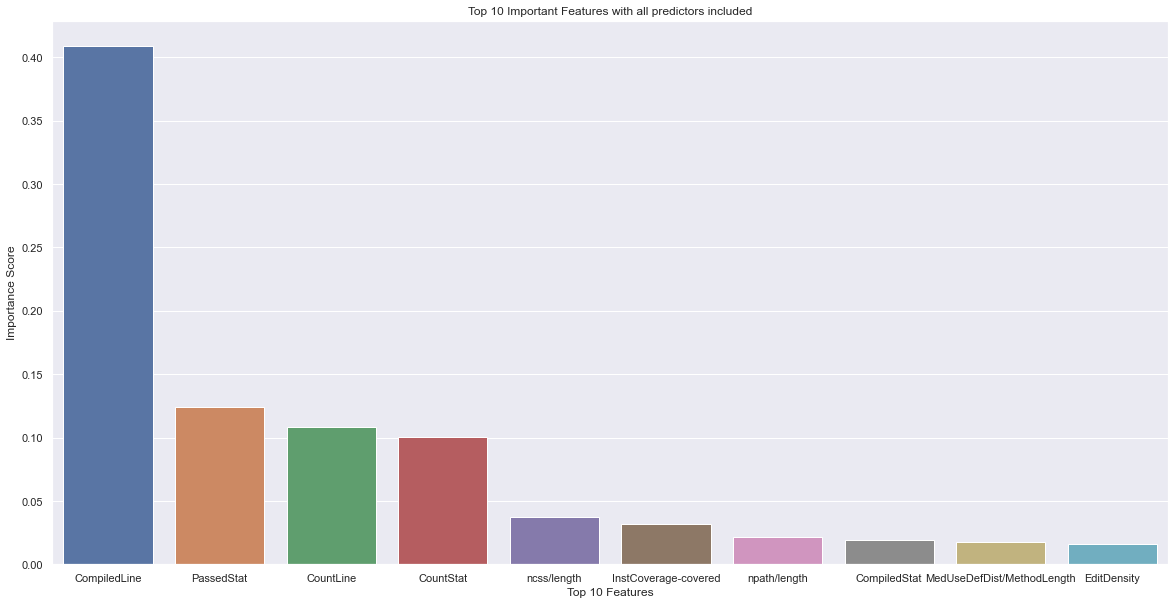

In [38]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (20, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Top 10 Important Features with all predictors included', xticklabels=top_10.index)

print(top_10)

##### This shows that the top 2 features reported is the number of passed lines and the proportion compiled. Some metrics are shown below.

In [ ]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.95385
Adj. R2: 0.95267
RMSE: 0.00049
MAE: 0.01016


## 5. Feature Selection

##### After getting the initial result with all features included, let's see what happens when we drop certain features, starting with PassedLine.

In [30]:
# Building a model, dropping PassedLine
X = df_new.drop(['PropStatCompiled', 'PropLinePassed', 'PropStatPassed', 'PassedLine'], axis=1)

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(647, 22)
(278, 22)
(647,)
(278,)


CompiledLine                  0.409908
CountLine                     0.119214
PassedStat                    0.118932
CountStat                     0.093390
ncss/length                   0.036949
InstCoverage-covered          0.033215
npath/length                  0.022631
cyc/length                    0.018633
MedUseDefDist/MethodLength    0.017637
CompiledStat                  0.017473
dtype: float64


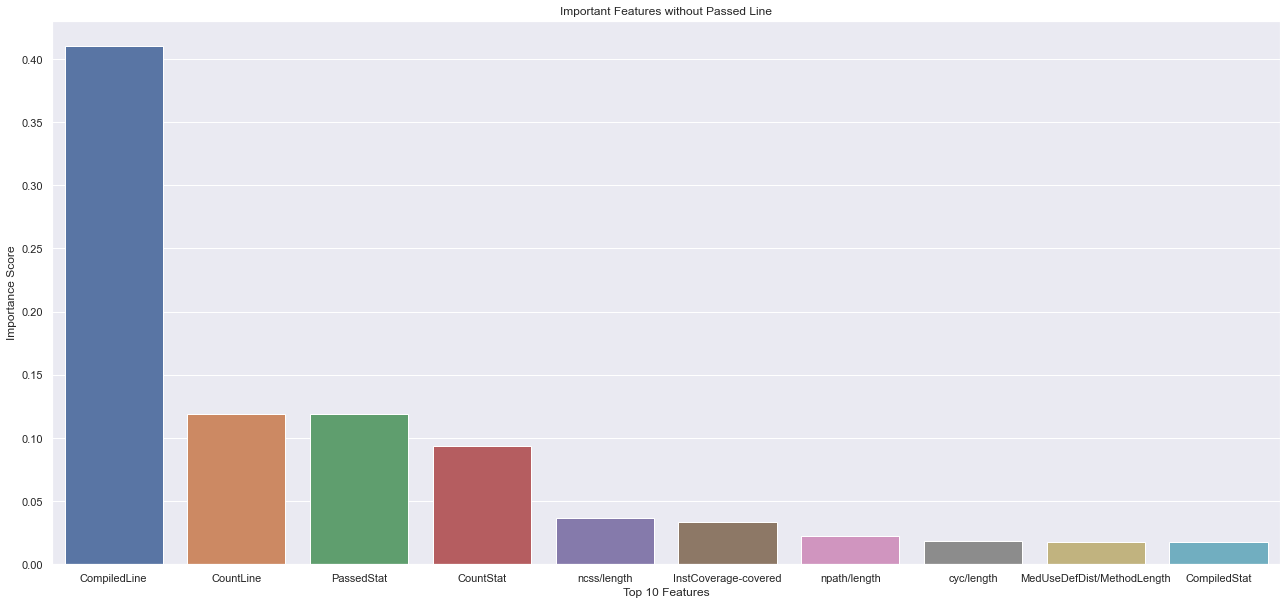

In [37]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features without Passed Line', xticklabels=top_10.index)

print(top_10)

In [32]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.67039
Adj. R2: 0.66235
RMSE: 0.00352
MAE: 0.04079


In [40]:
# Building a model with just the metrics
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)


(647, 8)
(278, 8)
(647,)
(278,)


ncss/length      0.192266
AveUseDefDist    0.169894
npath/length     0.141133
cyc/length       0.129392
MedDefUseDist    0.118345
dtype: float64


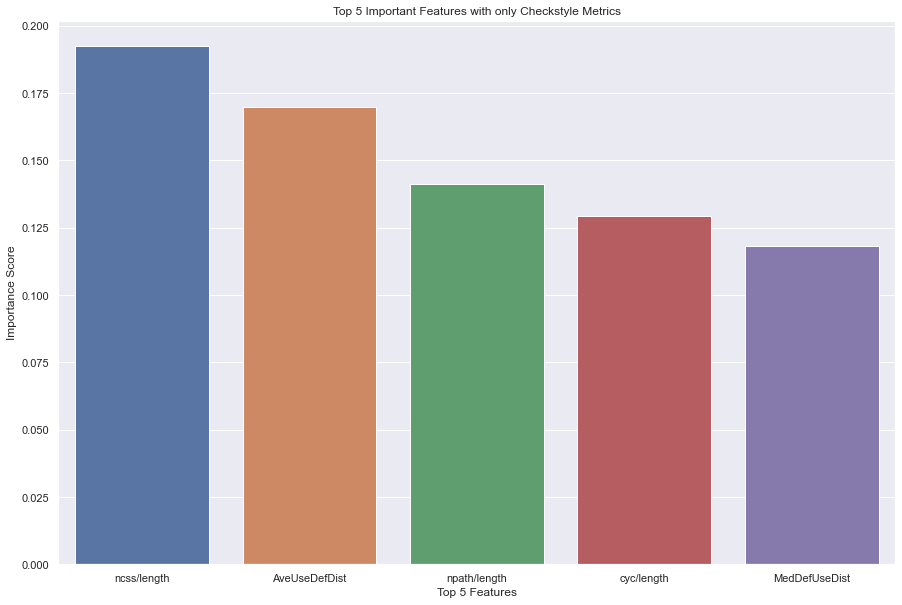

In [42]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(5)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (15, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 5 Features', ylabel='Importance Score', title='Top 5 Important Features with only Checkstyle Metrics', xticklabels=top_10.index)

print(top_10)

In [23]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.02754
Adj. R2: 0.01879
RMSE: 0.00922
MAE: 0.07360


In [24]:
# Building a model where the related compile features are removed
X = df_new.drop(['PropLinePassed', 'PropLineCompiled', 'CompiledLine', 'PropStatPassed', 'PropStatCompiled', 'PassedLine'], axis=1)

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(628, 24)
(270, 24)
(628,)
(270,)


PassedLine                    0.677152
CountStat                     0.125883
CountLine                     0.096996
PropStatPassed                0.038489
MethodIndex                   0.011743
PropStatCompiled              0.007636
cyc/length                    0.004836
npath/length                  0.004160
EditDensity                   0.003842
MedUseDefDist/MethodLength    0.003824
dtype: float64


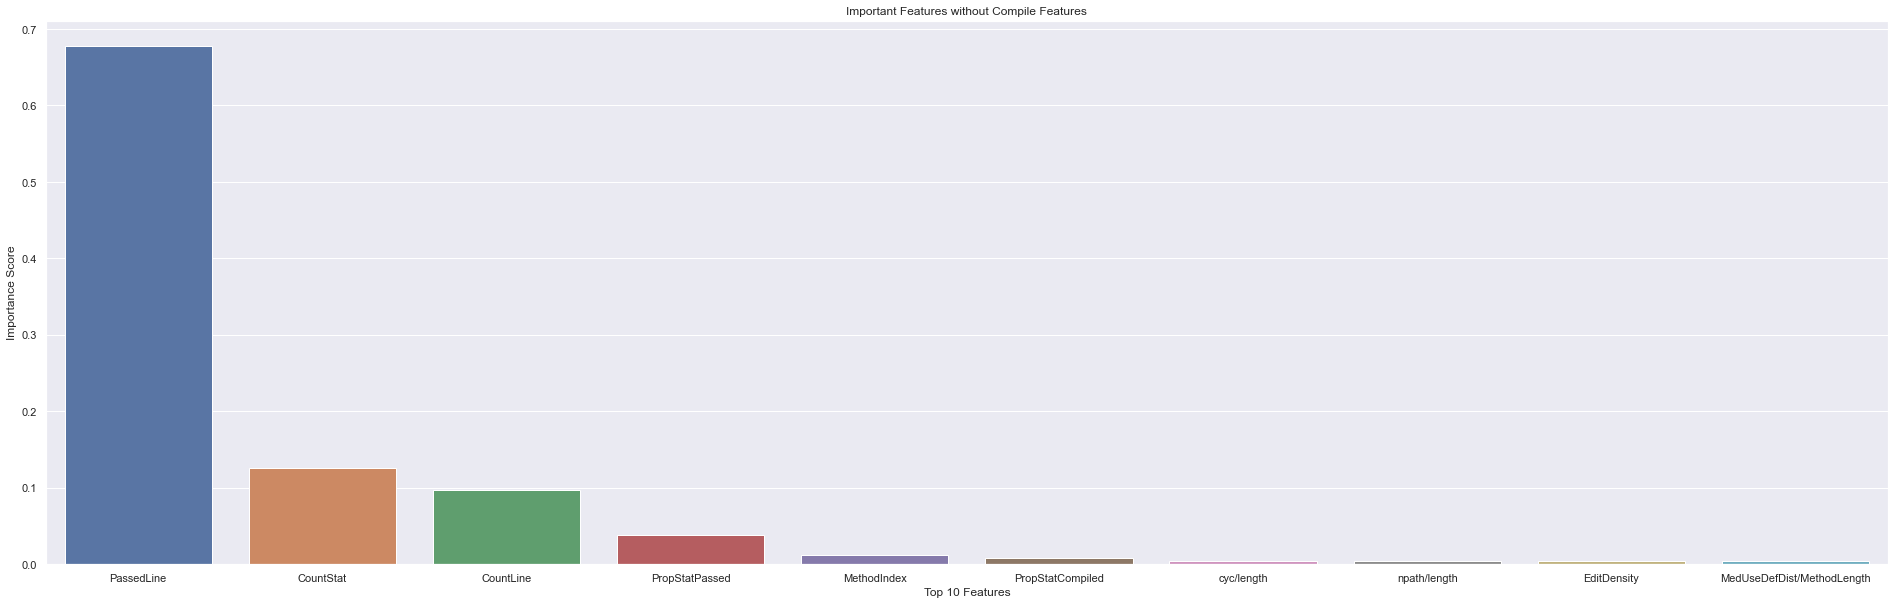

In [136]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (33, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features without Compile Features', xticklabels=top_10.index)

print(top_10)


In [35]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.71143
Adj. R2: 0.70315
RMSE: 0.00274
MAE: 0.03613


## 6. Model Evaluation

### 6.1.1 Ridge Regression without Tuning

In [59]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
ridge = Ridge() 

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")


R2 Score: 0.05419
Adj. R2: 0.04489
RMSE: 0.01010
MAE: 0.07470


### 6.1.2 Ridge Regression with Tuning

In [65]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
ridge = Ridge()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']

space['alpha'] = loguniform(1e-5, 100)

space['fit_intercept'] = [True, False]

space['normalize'] = [True, False]

# Define search
random_search = RandomizedSearchCV(ridge, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)

print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)



Random Search Best Score: -0.07388508585673864
Random Search Best Hyperparameters: {'alpha': 1.207012925789825, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


C:\Users\lj\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [64]:
ridge = Ridge(solver='sag', fit_intercept=True, normalize=True, alpha=1.207012925789825)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.04508
Adj. R2: 0.03569
RMSE: 0.01020
MAE: 0.07498


C:\Users\lj\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


### 6.2.1 KNN without Tuning

In [68]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
knnreg = KNeighborsRegressor()

knnreg.fit(X_train, y_train)

y_pred = knnreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -0.07173
Adj. R2: -0.08228
RMSE: 0.01145
MAE: 0.07993


### 6.2.2 KNN with Tuning

In [70]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
knnreg = KNeighborsRegressor()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()

space['algorithm'] = ['ball_tree', 'kd_tree', 'brute']

space['n_neighbors'] = [2, 3, 5, 10, 12, 15, 20, 25, 30, 40]

space['weights'] = ['uniform', 'distance']

space['leaf_size'] = [10, 30, 60, 80, 90, 120, 140]

space['p'] = [1, 2, 3]

# Define search
random_search = RandomizedSearchCV(knnreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)

print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)

Random Search Best Score: -0.07368948090813406
Random Search Best Hyperparameters: {'weights': 'distance', 'p': 3, 'n_neighbors': 40, 'leaf_size': 10, 'algorithm': 'ball_tree'}


In [69]:
knnreg = KNeighborsRegressor(n_neighbors=40, weights='distance', p=3, leaf_size=10, algorithm='ball_tree')

knnreg.fit(X_train, y_train)

y_pred = knnreg.predict(X_test)

r2 = r2_score(y_test, y_pred)
    
adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.00452
Adj. R2: -0.00527
RMSE: 0.01064
MAE: 0.07513


### 6.3.1 RandomForest without Tuning

In [14]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")
print(rforestreg.get_params())

R2 Score: 0.03618
Adj. R2: 0.02670
RMSE: 0.01030
MAE: 0.07512
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### 6.3.2 RandomForest with Tuning

In [ ]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
rforestreg = RandomForestRegressor()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()

space['n_estimators'] = [100, 250, 300, 350, 400, 450, 500]

space['bootstrap'] = [True, False]

space['warm_start'] = [True, False]

space['ccp_alpha'] = loguniform(1e-5, 100)

# Define search
random_search = RandomizedSearchCV(rforestreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)

print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)


In [15]:
rforestreg = RandomForestRegressor(n_estimators = 100, warm_start=True, bootstrap=True, ccp_alpha=0.0002927184992304148)

rforestreg.fit(X_train, y_train)

y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.06307
Adj. R2: 0.05385
RMSE: 0.01001
MAE: 0.07511


### 6.4.1 MLPRegressor without Tuning

In [73]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
mlpreg = MLPRegressor()

mlpreg.fit(X_train, y_train)

y_pred = mlpreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -16.04931
Adj. R2: -16.21701
RMSE: 0.18215
MAE: 0.16539


C:\Users\lj\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 6.4.2 MLPRegressor with Tuning

In [71]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLinePassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
mlpreg = MLPRegressor(max_iter=5500)

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['hidden_layer_sizes'] = [(50,50,50), (50,100,50), (100,1), (100, 50, 1)]

space['activation'] = ['relu', 'tanh', 'logistic']

space['alpha'] = loguniform(1e-5, 100)

space['learning_rate'] = ['constant', 'adaptive']

space['solver'] = ['adam', 'lbfgs']

# Define search
random_search = RandomizedSearchCV(mlpreg, space, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)
                     
print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)


Random Search Best Score: -0.07436788125013712
Random Search Best Hyperparameters: {'activation': 'tanh', 'alpha': 1.0275278736640157, 'hidden_layer_sizes': (100, 50, 1), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


In [74]:
mlpreg = MLPRegressor(activation='tanh', alpha=1.0275278736640157, hidden_layer_sizes=(100, 50, 1), learning_rate='adaptive', solver='lbfgs')

mlpreg.fit(X_train, y_train)

y_pred = mlpreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.02516
Adj. R2: 0.01557
RMSE: 0.01041
MAE: 0.07586
